In [28]:
import json
import random
import numpy as np
from collections import defaultdict
from itertools import combinations
import datetime
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt

In [29]:
# File paths for data
CARDS_JSON = "data/labeled_cards.json"
DECKS_JSON = "data/one_piece_deck_lists.json"
KNOWN_SYNERGIES_JSON = "graphs/card_synergies.json"

# Load data
with open(CARDS_JSON, "r") as f:
    cards_data = json.load(f)
with open(DECKS_JSON, "r") as f:
    decks_data = json.load(f)
with open(KNOWN_SYNERGIES_JSON, "r") as f:
    known_synergies_data = json.load(f)

print(f"Loaded {len(cards_data)} cards, {len(decks_data)} decks, and synergy data.")

Loaded 1307 cards, 1732 decks, and synergy data.


In [30]:
# Banned cards list (update as needed)
BANNED_CARDS = {"ST10-001", "OP03-098", "OP05-041", "ST06-015", "OP06-116", "OP02-024", "OP02-052"}

# Card ID to index mapping
card_id_to_index = {c["id"]: i for i, c in enumerate(cards_data)}

# List of leader cards
leaders = [c for c in cards_data if c["type"] == "Leader"]

# Traits, types, and labels for node features
ALL_TRAITS = sorted(set(t for c in cards_data for t in c.get("traits", [])))
trait2idx = {t: i for i, t in enumerate(ALL_TRAITS)}
NUM_TRAITS = len(trait2idx)

ALL_TYPES = sorted(set(c["type"] for c in cards_data))
type2idx = {t: i for i, t in enumerate(ALL_TYPES)}
NUM_TYPES = len(type2idx)

ALL_LABELS = sorted(set(label.strip() for card in cards_data for label in card.get("labels", [])))
label2idx = {label: i for i, label in enumerate(ALL_LABELS)}
NUM_LABELS = len(label2idx)

In [ ]:
def get_card_colors(card):
    ccol = card.get("color", [])
    if isinstance(ccol, str):
        ccol = [ccol]
    return ccol

def find_leader_in_deck(deck):
    for entry in deck:
        cid = list(entry.keys())[0]
        if any(l["id"] == cid for l in leaders):
            return cid
    return None

def deck_archetype(deck):
    lid = find_leader_in_deck(deck)
    if not lid:
        return ""
    leader_card = next((l for l in leaders if l["id"] == lid), None)
    return leader_card.get("archetype", "").strip() if leader_card else ""

def deck_matches_color_archetype(deck, leader_color, leader_arche):
    lid = find_leader_in_deck(deck)
    if not lid:
        return False
    leader_card = next((c for c in cards_data if c["id"] == lid), None)
    if not leader_card:
        return False
    deck_colors = get_card_colors(leader_card)
    deck_arch = leader_card.get("archetype", "").strip().lower()
    if not any(c in deck_colors for c in leader_color):
        return False
    return deck_arch == leader_arche.lower() if leader_arche else True

def gather_decks_for_color_archetype(leader_color, leader_arche, all_decks):
    filtered = [d for d in all_decks if deck_matches_color_archetype(d, leader_color, leader_arche)]
    if filtered:
        return filtered
    return [d for d in all_decks if any(c in get_card_colors(next((c for c in cards_data if c["id"] == find_leader_in_deck(d)), {})) for c in leader_color)]

In [ ]:
def multi_hot_trait_vector(card):
    vec = np.zeros(NUM_TRAITS, dtype=np.float32)
    for t in card.get("traits", []):
        if t in trait2idx:
            vec[trait2idx[t]] = 1.0
    return vec

def one_hot_type_vector(card):
    vec = np.zeros(NUM_TYPES, dtype=np.float32)
    vec[type2idx[card["type"]]] = 1.0
    return vec

def multi_hot_label_vector(card):
    vec = np.zeros(NUM_LABELS, dtype=np.float32)
    for label in card.get("labels", []):
        label = label.strip()
        if label in label2idx:
            vec[label2idx[label]] = 1.0
    return vec

def build_node_feature_with_traits(card, archetype_usage_map):
    cost_val = float(card.get("cost", 0))
    ctr_val = float(card.get("counter", 0))
    trait_vec = multi_hot_trait_vector(card)
    type_vec = one_hot_type_vector(card)
    label_vec = multi_hot_label_vector(card)
    base_features = np.array([cost_val, ctr_val], dtype=np.float32)
    return np.concatenate((base_features, trait_vec, type_vec, label_vec))

In [ ]:
def parse_known_synergies(known_synergies_data, synergy_weight=5.0, treat_as_undirected=True):
    synergy_edges = defaultdict(float)
    for ln in known_synergies_data.get("links", []):
        src, tgt = ln["source"], ln["target"]
        if src in card_id_to_index and tgt in card_id_to_index:
            synergy_edges[(src, tgt)] += synergy_weight
            if treat_as_undirected:
                synergy_edges[(tgt, src)] += synergy_weight
    return synergy_edges

def build_synergy_graph(relevant_decks, leader_arche, target_colors, synergy_weight=2.0, known_synergy_edges=None):
    G = nx.Graph()
    all_ids = {c["id"] for c in cards_data if any(col in c["color"] for col in target_colors)}
    G.add_nodes_from(all_ids)

    for deck in relevant_decks:
        lid = find_leader_in_deck(deck)
        if not lid:
            continue
        deck_arch = deck_archetype(deck)
        w_factor = synergy_weight if deck_arch.lower() == leader_arche.lower() else 1.0
        deck_cards = [cid for entry in deck for cid, count in entry.items() for _ in range(count) if cid != lid and cid in all_ids]
        for a, b in combinations(deck_cards, 2):
            if a == b:
                continue
            if G.has_edge(a, b):
                G[a][b]["weight"] += w_factor
            else:
                G.add_edge(a, b, weight=w_factor)

    if known_synergy_edges:
        for (src, tgt), w in known_synergy_edges.items():
            if src in all_ids and tgt in all_ids and src not in BANNED_CARDS and tgt not in BANNED_CARDS:
                if G.has_edge(src, tgt):
                    G[src][tgt]["weight"] += w
                else:
                    G.add_edge(src, tgt, weight=w)

    return G

def compute_card_frequency(relevant_decks):
    freq_map = defaultdict(int)
    for d in relevant_decks:
        lid = find_leader_in_deck(d)
        for entry in d:
            cid, cnt = list(entry.items())[0]
            if cid != lid and cnt > 0:
                freq_map[cid] += cnt
    return freq_map

def compute_archetype_usage_ratio(relevant_decks, leader_arche):
    usage_count = {c["id"]: 0 for c in cards_data}
    deck_count = len(relevant_decks)
    arche_decks = [d for d in relevant_decks if deck_archetype(d).lower() == leader_arche.lower()]
    for d in arche_decks:
        lid = find_leader_in_deck(d)
        for cid in {list(entry.keys())[0] for entry in d if list(entry.values())[0] > 0 and list(entry.keys())[0] != lid}:
            usage_count[cid] += 1
    return {c["id"]: usage_count[c["id"]] / deck_count for c in cards_data}

In [ ]:
def build_pyg_data(cards_data, synergy_graph, freq_map, archetype_usage_map):
    node_features = [build_node_feature_with_traits(c, archetype_usage_map) for c in cards_data]
    usage_list = [freq_map.get(c["id"], 0) for c in cards_data]
    
    edges, weights = [], []
    for u, v, data in synergy_graph.edges(data=True):
        if u in card_id_to_index and v in card_id_to_index:
            ui, vi = card_id_to_index[u], card_id_to_index[v]
            w = data["weight"]
            edges.extend([[ui, vi], [vi, ui]])
            weights.extend([w, w])
    
    x_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)
    edge_weight = torch.tensor(weights, dtype=torch.float) if weights else torch.empty((0,), dtype=torch.float)
    
    data_pyg = Data(x=x_tensor, edge_index=edge_index, edge_weight=edge_weight)
    node_labels = np.array(usage_list, dtype=np.float32)
    return data_pyg, node_labels

In [ ]:
class MultiTaskGNN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=128, emb_dim=64, dropout=0.5, num_layers=4):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = torch.nn.Dropout(dropout)
        self.convs = torch.nn.ModuleList([GCNConv(in_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])
        self.node_head = torch.nn.Linear(hidden_dim, 1)
        self.synergy_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = x
        for conv in self.convs:
            h = F.relu(self.dropout(conv(h, edge_index)))
        node_score = self.node_head(h).squeeze(-1)
        return h, node_score

    def predict_synergy(self, hu, hv):
        inp = torch.cat([hu, hv], dim=-1)
        return self.synergy_mlp(inp).squeeze(-1)

In [ ]:
def sample_negative_edges(edge_index, num_nodes, num_neg, cards_data, card_id_to_index):
    existing = {(edge_index[0, i].item(), edge_index[1, i].item()) for i in range(edge_index.shape[1])}
    neg = []
    attempts = 0
    while len(neg) < num_neg and attempts < 500000:
        attempts += 1
        a_idx, b_idx = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
        if a_idx == b_idx or (a_idx, b_idx) in existing:
            continue
        a_colors = set(get_card_colors(cards_data[a_idx]))
        b_colors = set(get_card_colors(cards_data[b_idx]))
        if a_colors & b_colors:
            neg.append((a_idx, b_idx))
    return neg

def train_gnn(model, data, node_labels_np, epochs=300, lr=0.005, neg_factor=2.0, synergy_loss_weight=2.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    mean_val = node_labels_np.mean()
    std_val = max(node_labels_np.std(), 1e-9)
    node_labels_norm = (node_labels_np - mean_val) / std_val
    node_labels_t = torch.tensor(node_labels_norm, dtype=torch.float, device=device)
    
    best_loss = float('inf')
    patience, no_improve = 20, 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        node_emb, node_score = model(data)
        loss_node = F.mse_loss(node_score, node_labels_t)
        
        pos_u, pos_v, pos_w = [], [], []
        for i in range(0, data.edge_index.shape[1], 2):
            u, v, w = data.edge_index[0, i].item(), data.edge_index[1, i].item(), data.edge_weight[i].item()
            pos_u.append(u)
            pos_v.append(v)
            pos_w.append(np.log1p(w))
        
        loss_synergy = 0.0
        if pos_u:
            pos_u_t = torch.tensor(pos_u, dtype=torch.long, device=device)
            pos_v_t = torch.tensor(pos_v, dtype=torch.long, device=device)
            pos_w_t = torch.tensor(pos_w, dtype=torch.float, device=device)
            num_neg = int(len(pos_u) * neg_factor)
            neg_edges = sample_negative_edges(data.edge_index, data.x.shape[0], num_neg, cards_data, card_id_to_index)
            neg_u = torch.tensor([e[0] for e in neg_edges], dtype=torch.long, device=device)
            neg_v = torch.tensor([e[1] for e in neg_edges], dtype=torch.long, device=device)
            neg_w_t = torch.zeros(len(neg_edges), dtype=torch.float, device=device)
            all_u = torch.cat([pos_u_t, neg_u])
            all_v = torch.cat([pos_v_t, neg_v])
            all_w = torch.cat([pos_w_t, neg_w_t])
            hu, hv = node_emb[all_u], node_emb[all_v]
            synergy_pred = model.predict_synergy(hu, hv)
            loss_synergy = F.mse_loss(synergy_pred, all_w)
        
        loss = loss_node + synergy_loss_weight * loss_synergy
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            no_improve = 0
        else:
            no_improve += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Node Loss: {loss_node.item():.4f}, Synergy Loss: {loss_synergy:.4f}, Total: {loss.item():.4f}")
        
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return model, mean_val, std_val

In [ ]:
def build_synergy_matrix(model, data, freq_map, node_labels_np, mean_val, std_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        node_emb, node_score_t = model(data)
    node_emb = node_emb.cpu()
    node_score = node_score_t.cpu().numpy() * std_val + mean_val
    for i, c in enumerate(cards_data):
        if freq_map.get(c["id"], 0) == 0:
            node_score[i] -= 2.0  # Penalty for unused cards
    
    num_cards = len(cards_data)
    synergy_matrix = np.zeros((num_cards, num_cards), dtype=np.float32)
    for i in range(num_cards):
        hi = node_emb[i].unsqueeze(0).to(device)
        hj = node_emb.to(device)
        synergies = model.predict_synergy(hi.expand(num_cards, -1), hj).detach().cpu().numpy()
        synergy_matrix[i, :] = synergies
        synergy_matrix[:, i] = synergies  # Ensure symmetry
        synergy_matrix[i, i] = max(0.1, node_score[i])
    
    return synergy_matrix, node_score

In [ ]:
def save_model(model, filename):
    models_dir = "models"
    archive_dir = os.path.join(models_dir, "archive")
    os.makedirs(models_dir, exist_ok=True)
    file_path = os.path.join(models_dir, filename)
    if os.path.exists(file_path):
        os.makedirs(archive_dir, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        os.rename(file_path, os.path.join(archive_dir, f"{timestamp}_{filename}"))
        print(f"Existing model archived to: {timestamp}_{filename}")
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to: {file_path}")

def load_model(model, filepath):
    if os.path.exists(filepath):
        model.load_state_dict(torch.load(filepath))
        print(f"Model loaded from: {filepath}")
    else:
        print(f"Model file not found: {filepath}")
    return model

In [ ]:
def train_and_build_synergy_per_leader(target_leader_id):
    leader_card = next((c for c in leaders if c["id"] == target_leader_id), None)
    if not leader_card:
        raise ValueError(f"Leader ID {target_leader_id} not found!")
    
    leader_color = get_card_colors(leader_card)
    leader_arche = leader_card.get("archetype", "").strip()
    relevant_decks = gather_decks_for_color_archetype(leader_color, leader_arche, decks_data) or decks_data
    
    known_synergy_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0)
    synergy_graph = build_synergy_graph(relevant_decks, leader_arche, leader_color, synergy_weight=2.0, known_synergy_edges=known_synergy_edges)
    freq_map = compute_card_frequency(relevant_decks)
    archetype_usage_map = compute_archetype_usage_ratio(relevant_decks, leader_arche)
    
    data_pyg, node_labels_np = build_pyg_data(cards_data, synergy_graph, freq_map, archetype_usage_map)
    in_dim = data_pyg.x.shape[1]
    model = MultiTaskGNN(in_dim=in_dim, hidden_dim=128, emb_dim=64, dropout=0.5, num_layers=4)
    model, mean_val, std_val = train_gnn(model, data_pyg, node_labels_np, epochs=300, lr=0.005, neg_factor=2.0, synergy_loss_weight=2.0)
    save_model(model, f"gnn_model_{target_leader_id}.pth")
    
    synergy_matrix, node_score = build_synergy_matrix(model, data_pyg, freq_map, node_labels_np, mean_val, std_val)
    return synergy_matrix, node_score, relevant_decks

In [ ]:
def evaluate_synergy_prediction_accuracy(model, data, known_synergy_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        node_emb, _ = model(data)
    preds, actuals = [], []
    for (src, tgt), w in known_synergy_data.items():
        if src in card_id_to_index and tgt in card_id_to_index:
            i, j = card_id_to_index[src], card_id_to_index[tgt]
            pred = model.predict_synergy(node_emb[i].unsqueeze(0), node_emb[j].unsqueeze(0)).item()
            preds.append(pred)
            actuals.append(np.log1p(w))
    if not preds:
        print("No known synergy edges found for evaluation.")
        return
    mse = np.mean((np.array(preds) - np.array(actuals))**2)
    print(f"Synergy Prediction MSE on Known Edges: {mse:.4f}")

    return mse

def evaluate_deck(deck, synergy_matrix, node_score, singleton_penalty=10.0, max_singleton_ratio=0.3):
    deck_arr = np.array(deck, dtype=np.float32)
    total_score = np.dot(node_score, deck_arr)
    synergy_total = 0.5 * (deck_arr @ synergy_matrix @ deck_arr - np.sum(deck_arr**2 * np.diag(synergy_matrix)))
    base_score = total_score + synergy_total
    total_copies = deck_arr.sum()
    num_singletons = np.sum(deck_arr == 1)
    ratio = num_singletons / total_copies if total_copies > 0 else 0
    penalty = singleton_penalty * (ratio - max_singleton_ratio) * total_copies if ratio > max_singleton_ratio else 0
    return base_score - penalty

def greedy_initial_deck(valid_indices, node_score, deck_size, max_copies):
    deck = [0] * len(cards_data)
    sorted_indices = sorted(valid_indices, key=lambda i: node_score[i], reverse=True)
    remaining = deck_size
    for i in sorted_indices:
        copies = min(max_copies, remaining)
        deck[i] = copies
        remaining -= copies
        if remaining <= 0:
            break
    return deck

def local_search_deck(current_deck, synergy_matrix, node_score, iterations=1000000,
                      singleton_penalty=20.0, max_singleton_ratio=0.2, deck_size=50,
                      max_copies=4, valid_indices=None, early_stop=500):
    # Initialize best deck and score
    best_deck = current_deck[:]
    best_score = evaluate_deck(best_deck, synergy_matrix, node_score, singleton_penalty, max_singleton_ratio)
    current_deck = best_deck[:]
    no_improve = 0
    
    # Precompute valid indices if not provided
    if valid_indices is None:
        valid_indices = list(range(len(current_deck)))
    
    for it in range(iterations):
        neighbor = current_deck[:]
        # Get cards currently in the deck
        nonzero = [i for i, count in enumerate(neighbor) if count > 0]
        if not nonzero:
            continue
        
        # Remove one card
        remove_idx = random.choice(nonzero)
        neighbor[remove_idx] -= 1
        
        # Decide whether to add to an existing card or a new one
        existing_cards = [i for i in nonzero if neighbor[i] < max_copies]
        new_cards = [i for i in valid_indices if neighbor[i] == 0]
        
        # Bias toward adding to existing cards (70% chance if possible)
        if existing_cards and (not new_cards or random.random() < 0.7):
            add_idx = random.choice(existing_cards)
        elif new_cards:
            add_idx = random.choice(new_cards)
        else:
            continue  # No valid move possible
        
        neighbor[add_idx] += 1
        
        # Ensure deck size constraint
        if sum(neighbor) != deck_size:
            continue
        
        # Evaluate the new deck
        neighbor_score = evaluate_deck(neighbor, synergy_matrix, node_score, singleton_penalty, max_singleton_ratio)
        
        # Accept move if it improves the score or occasionally for exploration
        if neighbor_score > best_score or random.random() < 0.05:
            current_deck = neighbor[:]
            if neighbor_score > best_score:
                best_score = neighbor_score
                best_deck = neighbor[:]
                no_improve = 0
                if (it + 1) % 10000 == 0:  # Less frequent logging
                    print(f"Iteration {it+1}: Improved score to {best_score:.2f}")
            else:
                no_improve += 1
        else:
            no_improve += 1
        
        # Early stopping
        if no_improve >= early_stop:
            print(f"Early stopping at iteration {it+1}, Best Score: {best_score:.2f}")
            break
    
    return best_deck

def build_deck_local_search(target_leader_id, synergy_matrix, node_score, deck_size=50,
                            max_copies=4, iterations=1000000, singleton_penalty=20.0,
                            max_singleton_ratio=0.2):
    leader_card = next((c for c in cards_data if c["id"] == target_leader_id), None)
    if not leader_card:
        raise ValueError(f"Leader {target_leader_id} not found")
    leader_color = set(get_card_colors(leader_card))
    valid_indices = [i for i, card in enumerate(cards_data) if card["id"] not in BANNED_CARDS and card["type"] != "Leader" and leader_color & set(get_card_colors(card))]
    
    initial_deck = greedy_initial_deck(valid_indices, node_score, deck_size, max_copies)
    return local_search_deck(initial_deck, synergy_matrix, node_score, iterations, singleton_penalty, max_singleton_ratio, deck_size, max_copies, valid_indices)

In [ ]:
def print_deck_list(deck, leader_id):
    leader_card = next((c for c in cards_data if c["id"] == leader_id), None)
    print(f"=== DECK for Leader {leader_id} ({leader_card.get('name', 'Unknown')}) ===")
    total = 0
    for i, copies in enumerate(deck):
        if copies > 0:
            cid, name = cards_data[i]["id"], cards_data[i]["name"]
            print(f"{copies}x {cid} - {name}")
            total += copies
    print(f"Total non-leader cards: {total}")

def evaluate_deck_vs_meta(deck, relevant_decks):
    meta_freq = compute_card_frequency(relevant_decks)
    deck_freq_map = {cards_data[i]["id"]: copies for i, copies in enumerate(deck) if copies > 0}
    sorted_meta = sorted(meta_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 cards in meta (by usage):")
    for cid, freq in sorted_meta:
        nm = next((c["name"] for c in cards_data if c["id"] == cid), cid)
        print(f"{cid} - {nm}: {freq}")
    overlap = len(set(deck_freq_map.keys()) & {cid for cid, _ in sorted_meta})
    print(f"Deck shares {overlap} of the meta's top 10 cards.")

def synergy_heatmap(deck, synergy_matrix, diagonal= 1.0, title="Deck Synergy Heatmap"):
    deck_idxs = [i for i, cpy in enumerate(deck) if cpy > 0]
    if not deck_idxs:
        print("No cards in deck to visualize.")
        return
    sub_matrix = synergy_matrix[np.ix_(deck_idxs, deck_idxs)]
    np.fill_diagonal(sub_matrix, diagonal)
    plt.figure(figsize=(8, 6))
    plt.imshow(sub_matrix, aspect='auto', origin='upper', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Card Index in Deck")
    plt.ylabel("Card Index in Deck")
    plt.show()

def inspect_synergy_predictions(deck, synergy_matrix):
    for i, copies in enumerate(deck):
        if copies > 0:
            name = cards_data[i]["name"]
            best_synergy = np.argsort(synergy_matrix[i])[::-1]
            print(f"Top 3 cards with highest synergy for {name}:")
            count = 0
            for j in best_synergy:
                if deck[j] == 0:
                    print(f"{cards_data[j]['name']} - Synergy: {synergy_matrix[i, j]:.2f}")
                    count += 1
                    if count == 3:
                        break
            print(f"Top 3 cards with lowest synergy for {name}:")
            count = 0
            for j in np.argsort(synergy_matrix[i]):
                if deck[j] == 0:
                    print(f"{cards_data[j]['name']} - Synergy: {synergy_matrix[i, j]:.2f}")
                    count += 1
                    if count == 3:
                        break
            print()

def generate_deck_graph(deck, synergy_matrix, title="Deck Graph", ):
    G = nx.Graph()
    for i, copies in enumerate(deck):
        if copies > 0:
            G.add_node(cards_data[i]["name"])
    for i, copies in enumerate(deck):
        if copies > 0:
            for j, copies2 in enumerate(deck):
                if copies2 > 0:
                    G.add_edge(cards_data[i]["name"], cards_data[j]["name"], weight=synergy_matrix[i, j])
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

In [43]:
# Define target leader
target_leader_id = "OP01-001"  # Roronoa Zoro

In [44]:
# print("Training GNN and Building Synergy Matrix...")
synergy_matrix, node_score, relevant_decks = train_and_build_synergy_per_leader(target_leader_id)

Epoch 10/300 - Node Loss: 36.0257, Synergy Loss: 2.6524, Total: 41.3305
Epoch 20/300 - Node Loss: 4.3257, Synergy Loss: 2.5172, Total: 9.3602
Epoch 30/300 - Node Loss: 1.6228, Synergy Loss: 2.3075, Total: 6.2379
Epoch 40/300 - Node Loss: 1.0628, Synergy Loss: 2.1740, Total: 5.4109
Epoch 50/300 - Node Loss: 1.0170, Synergy Loss: 2.0943, Total: 5.2055
Epoch 60/300 - Node Loss: 1.0271, Synergy Loss: 2.0474, Total: 5.1219
Epoch 70/300 - Node Loss: 1.0962, Synergy Loss: 1.9333, Total: 4.9627
Epoch 80/300 - Node Loss: 1.1885, Synergy Loss: 1.7075, Total: 4.6036
Epoch 90/300 - Node Loss: 1.2314, Synergy Loss: 1.3183, Total: 3.8679
Epoch 100/300 - Node Loss: 1.3644, Synergy Loss: 1.1650, Total: 3.6945
Epoch 110/300 - Node Loss: 1.2251, Synergy Loss: 1.1142, Total: 3.4534
Epoch 120/300 - Node Loss: 1.3095, Synergy Loss: 1.0818, Total: 3.4731
Epoch 130/300 - Node Loss: 1.2297, Synergy Loss: 1.0459, Total: 3.3214
Epoch 140/300 - Node Loss: 1.2048, Synergy Loss: 0.9556, Total: 3.1161
Epoch 150/300

In [48]:
print("\nBuilding Deck with Local Search...")
best_deck = build_deck_local_search(target_leader_id, synergy_matrix, node_score,
                                    deck_size=50, max_copies=4, iterations=100000, max_singleton_ratio=0.1)


Building Deck with Local Search...
Early stopping at iteration 574, Best Score: 3546.44


In [49]:
# Evaluate and visualize
print("\nDeck List:")
print_deck_list(best_deck, target_leader_id)


Deck List:
=== DECK for Leader OP01-001 (Roronoa Zoro) ===
3x OP01-026 - Gum-Gum Red Hawk
3x OP01-029 - Radical Beam!!
2x OP01-017 - Nico Robin
3x ST01-014 - Guard Point
3x ST01-006 - Tony Tony Chopper
2x ST01-004 - Sanji
3x ST01-007 - Nami
2x OP02-004 - Edward Newgate
2x OP02-005 - Curly Dadan
3x OP02-015 - Makino
3x OP02-016 - Magra
3x P-013 - Gordon
3x P-014 - Koby
3x P-019 - Bepo
3x OP03-018 - Fire Fist
3x OP03-019 - Fiery Doll
3x OP04-016 - Bad Manners Kick Course
1x OP05-010 - Nico Robin
2x OP05-011 - Bartholomew Kuma
Total non-leader cards: 50


In [50]:
print("\nEvaluating Deck vs. Meta:")
evaluate_deck_vs_meta(best_deck, relevant_decks)


Evaluating Deck vs. Meta:
Top 10 cards in meta (by usage):
OP01-025 - Roronoa Zoro: 524
OP01-006 - Otama: 492
OP02-015 - Makino: 458
OP02-005 - Curly Dadan: 452
OP01-016 - Nami: 421
ST01-011 - Brook: 327
OP03-013 - Marco: 301
OP03-008 - Buggy: 295
ST01-015 - Jet Pistol: 292
OP02-016 - Magra: 292
Deck shares 3 of the meta's top 10 cards.



Synergy Heatmap:


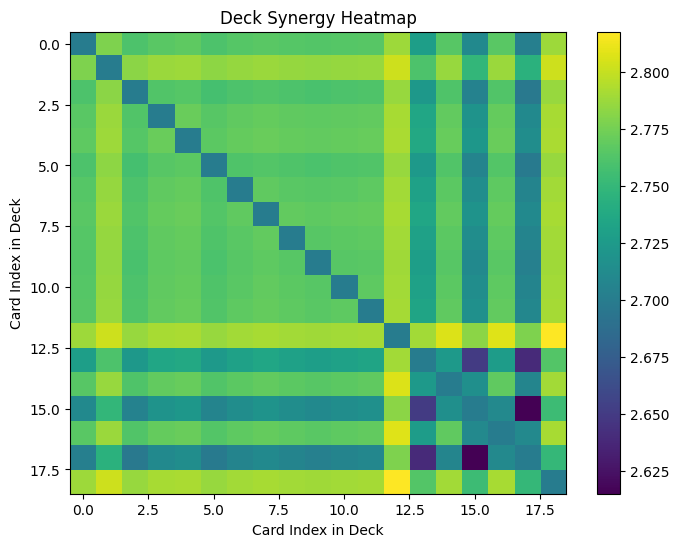

In [61]:
print("\nSynergy Heatmap:")
synergy_heatmap(best_deck, synergy_matrix, diagonal=2.7)

In [52]:
print("\nInspecting Synergy Predictions:")
inspect_synergy_predictions(best_deck, synergy_matrix)


Inspecting Synergy Predictions:
Top 3 cards with highest synergy for Gum-Gum Red Hawk:
In 2 years!!! To Sabaody - Synergy: 2.81
Buggy - Synergy: 2.79
Mr. Tanaka - Synergy: 2.79
Top 3 cards with lowest synergy for Gum-Gum Red Hawk:
Sakazuki - Synergy: 0.24
Three Sword Style: Oni Giri - Synergy: 0.24
King - Synergy: 0.25

Top 3 cards with highest synergy for Radical Beam!!:
In 2 years!!! To Sabaody - Synergy: 2.81
Nami - Synergy: 2.81
Striker - Synergy: 2.80
Top 3 cards with lowest synergy for Radical Beam!!:
Sakazuki - Synergy: 0.24
Three Sword Style: Oni Giri - Synergy: 0.25
King - Synergy: 0.25

Top 3 cards with highest synergy for Nico Robin:
In 2 years!!! To Sabaody - Synergy: 2.80
Nami - Synergy: 2.80
Carrot - Synergy: 2.80
Top 3 cards with lowest synergy for Nico Robin:
Sakazuki - Synergy: 0.24
Three Sword Style: Oni Giri - Synergy: 0.24
King - Synergy: 0.25

Top 3 cards with highest synergy for Guard Point:
In 2 years!!! To Sabaody - Synergy: 2.81
Nami - Synergy: 2.81
Carrot - S

In [ ]:
generate_deck_graph(best_deck, synergy_matrix)

In [36]:
evaluation_dir = "evaluations"
os.makedirs(evaluation_dir, exist_ok=True)

In [64]:
# Number of trials per leader
num_trials = 20

# Number of deck samples for evaluation
num_deck_trials = 250

# List of selected leaders for evaluation
selected_leader_ids = [
    # "OP01-001", # Roronoa Zoro Aggro
    "ST02-001", # Eustass Kid Midrange
    "ST13-003", # Monkey D. Luffy Combo
    "OP07-079", # Lucci Control
    "OP08-098" # Kalgara OP08
    ]

selected_leaders = []
for leader_id in selected_leader_ids:
    leader = next((l for l in leaders if l["id"] == leader_id), None)
    if leader:
        selected_leaders.append(leader)
        print(f"Confirmed leader: {leader_id} ({leader['name']}) - {leader.get('archetype', 'Unknown')}")
    else:
        print(f"Warning: Leader {leader_id} not found in cards_data!")

Confirmed leader: ST02-001 (Eustass Captain Kid) - Midrange
Confirmed leader: ST13-003 (Monkey.D.Luffy) - Combo
Confirmed leader: OP07-079 (Rob Lucci) - Control
Confirmed leader: OP08-098 (Kalgara) - Midrange


In [69]:
# Run evaluations for each selected leader
for leader in selected_leaders:
    leader_id = leader["id"]
    leader_dir = os.path.join(evaluation_dir, leader_id)
    os.makedirs(leader_dir, exist_ok=True)
    
    print(f"\n=== Evaluating Leader: {leader_id} ({leader['name']}) ===")
    
    # Gather relevant decks once per leader (to avoid recomputing unnecessarily)
    leader_color = get_card_colors(leader)
    leader_arche = leader.get("archetype", "").strip()
    relevant_decks = gather_decks_for_color_archetype(leader_color, leader_arche, decks_data) or decks_data
    
    # Run multiple GNN training trials
    all_trial_results = []
    for trial in range(1, num_trials + 1):
        print(f"\nGNN Trial {trial}/{num_trials}")
        
        # Train GNN and build synergy matrix for this trial
        print("Training GNN and building synergy matrix...")
        synergy_matrix, node_score, _ = train_and_build_synergy_per_leader(leader_id)
        
        # Generate multiple deck samples for this model
        deck_results = []
        for deck_trial in range(1, num_deck_trials + 1):
            if deck_trial % 100 == 0:  # Progress update
                print(f"  Deck Trial {deck_trial}/{num_deck_trials}")
            
            # Build deck using local search
            best_deck = build_deck_local_search(
                leader_id, synergy_matrix, node_score,
                deck_size=50, max_copies=4, iterations=100000,
                singleton_penalty=20.0, max_singleton_ratio=0.1
            )
            
            # Evaluate deck score
            deck_score = evaluate_deck(best_deck, synergy_matrix, node_score, singleton_penalty=20.0, max_singleton_ratio=0.1)
            
            # Compare to meta (UF2)
            meta_overlap = None
            if relevant_decks:
                meta_freq = compute_card_frequency(relevant_decks)
                sorted_meta = sorted(meta_freq.items(), key=lambda x: x[1], reverse=True)[:10]
                deck_cards = [cards_data[i]["id"] for i, copies in enumerate(best_deck) if copies > 0]
                meta_top_cards = {cid for cid, _ in sorted_meta}
                meta_overlap = len(set(deck_cards) & meta_top_cards)
            
            # Calculate heuristic indicators (UF3)
            deck_idxs = [i for i, copies in enumerate(best_deck) if copies > 0]
            avg_synergy = 0.0
            if len(deck_idxs) > 1:
                synergies = [synergy_matrix[i, j] for i in deck_idxs for j in deck_idxs if i < j]
                avg_synergy = np.mean(synergies) if synergies else 0.0
            num_singletons = sum(1 for copies in best_deck if copies == 1)
            
            # Store deck trial data
            deck_data = {
                "deck_trial": deck_trial,
                "deck": {cards_data[i]["id"]: int(copies) for i, copies in enumerate(best_deck) if copies > 0},
                "score": float(deck_score),
                "meta_overlap": meta_overlap,
                "avg_synergy": float(avg_synergy),
                "num_singletons": int(num_singletons)
            }
            deck_results.append(deck_data)
        
        # Store GNN trial data
        trial_data = {
            "gnn_trial": trial,
            "deck_results": deck_results
        }
        all_trial_results.append(trial_data)
        
        # Save individual GNN trial result
        with open(os.path.join(leader_dir, f"gnn_trial_{trial}.json"), "w") as f:
            json.dump(trial_data, f, indent=2)
        
        print(f"GNN Trial {trial} completed with {num_deck_trials} decks.")
    
    # Save all trials in one file per leader
    with open(os.path.join(leader_dir, "all_trials.json"), "w") as f:
        json.dump(all_trial_results, f, indent=2)
    
    print(f"Evaluations for {leader_id} completed. Results saved in {leader_dir}")

print("\nAll evaluations completed. Results are stored in the 'evaluations' directory.")


=== Evaluating Leader: ST02-001 (Eustass Captain Kid) ===

GNN Trial 1/20
Training GNN and building synergy matrix...
Epoch 10/300 - Node Loss: 8.8250, Synergy Loss: 2.5795, Total: 13.9841
Epoch 20/300 - Node Loss: 2.8081, Synergy Loss: 2.4369, Total: 7.6818
Epoch 30/300 - Node Loss: 1.3433, Synergy Loss: 2.3109, Total: 5.9651
Epoch 40/300 - Node Loss: 1.0433, Synergy Loss: 2.2083, Total: 5.4598
Epoch 50/300 - Node Loss: 1.0029, Synergy Loss: 2.1166, Total: 5.2360
Epoch 60/300 - Node Loss: 1.0026, Synergy Loss: 2.0307, Total: 5.0641
Epoch 70/300 - Node Loss: 1.0025, Synergy Loss: 1.9524, Total: 4.9072
Epoch 80/300 - Node Loss: 1.0045, Synergy Loss: 1.8828, Total: 4.7701
Epoch 90/300 - Node Loss: 1.0674, Synergy Loss: 1.7975, Total: 4.6624
Epoch 100/300 - Node Loss: 1.0853, Synergy Loss: 1.6945, Total: 4.4743
Epoch 110/300 - Node Loss: 1.0963, Synergy Loss: 1.4890, Total: 4.0743
Epoch 120/300 - Node Loss: 1.3303, Synergy Loss: 1.1660, Total: 3.6623
Epoch 130/300 - Node Loss: 1.1661, Sy

In [18]:
import pandas as pd
from itertools import combinations
from copy import deepcopy

In [19]:
EVAL_DIR = "evaluations"

In [ ]:
def load_evaluation_decks(leader_id):
    path = os.path.join(EVAL_DIR, leader_id, "all_trials.json")
    if not os.path.exists(path):
        return pd.DataFrame()
    with open(path,"r") as f:
        data = json.load(f)
    rows=[]
    for trial_info in data:
        gnn_trial = trial_info["gnn_trial"]
        for deck_res in trial_info["deck_results"]:
            dt = deck_res["deck_trial"]
            sc = deck_res["score"]
            mo = deck_res["meta_overlap"]
            avs= deck_res["avg_synergy"]
            ns = deck_res["num_singletons"]
            deck_data = deck_res["deck"]  # dict {card_id:count}
            deck_size = sum(deck_data.values())
            rows.append({
                "leader": leader_id,
                "gnn_trial": gnn_trial,
                "deck_trial": dt,
                "score": sc,
                "meta_overlap": mo,
                "avg_synergy": avs,
                "num_singletons": ns,
                "deck_size": deck_size
            })
    return pd.DataFrame(rows)

In [ ]:
#"OP01-001", # Roronoa Zoro Aggro
#"ST02-001", # Eustass Kid Midrange
#"ST13-003", # Monkey D. Luffy Combo
#"OP07-079", # Lucci Control
#"OP08-098" # Kalgara Midrange OP08
trial_models = {
    "OP01-001": {
        1: "models/archive/20250310_020344_gnn_model_OP01-001.pth",
        2: "models/archive/20250310_020841_gnn_model_OP01-001.pth",
        3: "models/archive/20250310_021402_gnn_model_OP01-001.pth",
        4: "models/archive/20250310_021918_gnn_model_OP01-001.pth",
        5: "models/archive/20250310_022357_gnn_model_OP01-001.pth",
        6: "models/archive/20250310_022638_gnn_model_OP01-001.pth",
        7: "models/archive/20250310_023122_gnn_model_OP01-001.pth",
        8: "models/archive/20250310_023535_gnn_model_OP01-001.pth",
        9: "models/archive/20250310_023934_gnn_model_OP01-001.pth",
        10: "models/archive/20250310_024405_gnn_model_OP01-001.pth",
        11: "models/archive/20250310_024911_gnn_model_OP01-001.pth",
        12: "models/archive/20250310_025427_gnn_model_OP01-001.pth",
        13: "models/archive/20250310_092915_gnn_model_OP01-001.pth",
        14: "models/archive/20250310_093400_gnn_model_OP01-001.pth",
        15: "models/archive/20250310_093846_gnn_model_OP01-001.pth",
        16: "models/archive/20250310_094344_gnn_model_OP01-001.pth",
        17: "models/archive/20250310_094848_gnn_model_OP01-001.pth",
        18: "models/archive/20250310_095356_gnn_model_OP01-001.pth",
        19: "models/archive/20250310_095802_gnn_model_OP01-001.pth",
        20: "models/gnn_model_OP01-001.pth"
    },
    "ST02-001": {
        1: "models/archive/20250310_103954_gnn_model_ST02-001.pth",
        2: "models/archive/20250310_104430_gnn_model_ST02-001.pth",
        3: "models/archive/20250310_104856_gnn_model_ST02-001.pth",
        4: "models/archive/20250310_105312_gnn_model_ST02-001.pth",
        5: "models/archive/20250310_105928_gnn_model_ST02-001.pth",
        6: "models/archive/20250310_110312_gnn_model_ST02-001.pth",
        7: "models/archive/20250310_110844_gnn_model_ST02-001.pth",
        8: "models/archive/20250310_111152_gnn_model_ST02-001.pth",
        9: "models/archive/20250310_111730_gnn_model_ST02-001.pth",
        10: "models/archive/20250310_112328_gnn_model_ST02-001.pth",
        11: "models/archive/20250310_112748_gnn_model_ST02-001.pth",
        12: "models/archive/20250310_113235_gnn_model_ST02-001.pth",
        13: "models/archive/20250310_113852_gnn_model_ST02-001.pth",
        14: "models/archive/20250310_114537_gnn_model_ST02-001.pth",
        15: "models/archive/20250310_114905_gnn_model_ST02-001.pth",
        16: "models/archive/20250310_115601_gnn_model_ST02-001.pth",
        17: "models/archive/20250310_120249_gnn_model_ST02-001.pth",
        18: "models/archive/20250310_120930_gnn_model_ST02-001.pth",
        19: "models/archive/20250310_121534_gnn_model_ST02-001.pth",
        20: "models/gnn_model_ST02-001.pth"
    },
    "ST13-003": {
        1: "models/archive/20250310_124906_gnn_model_ST13-003.pth",
        2: "models/archive/20250310_130357_gnn_model_ST13-003.pth",
        3: "models/archive/20250310_131251_gnn_model_ST13-003.pth",
        4: "models/archive/20250310_132633_gnn_model_ST13-003.pth",
        5: "models/archive/20250310_134640_gnn_model_ST13-003.pth",
        6: "models/archive/20250310_140535_gnn_model_ST13-003.pth",
        7: "models/archive/20250310_142354_gnn_model_ST13-003.pth",
        8: "models/archive/20250310_144243_gnn_model_ST13-003.pth",
        9: "models/archive/20250310_150000_gnn_model_ST13-003.pth",
        10: "models/archive/20250310_151659_gnn_model_ST13-003.pth",
        11: "models/archive/20250310_153450_gnn_model_ST13-003.pth",
        12: "models/archive/20250310_155124_gnn_model_ST13-003.pth",
        13: "models/archive/20250310_160222_gnn_model_ST13-003.pth",
        14: "models/archive/20250310_161823_gnn_model_ST13-003.pth",
        15: "models/archive/20250310_162924_gnn_model_ST13-003.pth",
        16: "models/archive/20250310_163821_gnn_model_ST13-003.pth",
        17: "models/archive/20250310_164728_gnn_model_ST13-003.pth",
        18: "models/archive/20250310_170323_gnn_model_ST13-003.pth",
        19: "models/archive/20250310_171913_gnn_model_ST13-003.pth",
        20: "models/gnn_model_ST13-003.pth"
    },
    "OP07-079": {
        1: "models/archive/20250310_172729_gnn_model_OP07-079.pth",
        2: "models/archive/20250310_173145_gnn_model_OP07-079.pth",
        3: "models/archive/20250310_173602_gnn_model_OP07-079.pth",
        4: "models/archive/20250310_174026_gnn_model_OP07-079.pth",
        5: "models/archive/20250310_174414_gnn_model_OP07-079.pth",
        6: "models/archive/20250310_174837_gnn_model_OP07-079.pth",
        7: "models/archive/20250310_175230_gnn_model_OP07-079.pth",
        8: "models/archive/20250310_175541_gnn_model_OP07-079.pth",
        9: "models/archive/20250310_180005_gnn_model_OP07-079.pth",
        10: "models/archive/20250310_180252_gnn_model_OP07-079.pth",
        11: "models/archive/20250310_180633_gnn_model_OP07-079.pth",
        12: "models/archive/20250310_181033_gnn_model_OP07-079.pth",
        13: "models/archive/20250310_181501_gnn_model_OP07-079.pth",
        14: "models/archive/20250310_182015_gnn_model_OP07-079.pth",
        15: "models/archive/20250310_182453_gnn_model_OP07-079.pth",
        16: "models/archive/20250310_183141_gnn_model_OP07-079.pth",
        17: "models/archive/20250310_183437_gnn_model_OP07-079.pth",
        18: "models/archive/20250310_183954_gnn_model_OP07-079.pth",
        19: "models/archive/20250310_184357_gnn_model_OP07-079.pth",
        20: "models/gnn_model_OP07-079.pth"
    },
    "OP08-098": {
        1: "models/archive/20250310_185753_gnn_model_OP08-098.pth",
        2: "models/archive/20250310_190439_gnn_model_OP08-098.pth",
        3: "models/archive/20250310_191003_gnn_model_OP08-098.pth",
        4: "models/archive/20250310_191656_gnn_model_OP08-098.pth",
        5: "models/archive/20250310_192424_gnn_model_OP08-098.pth",
        6: "models/archive/20250310_192859_gnn_model_OP08-098.pth",
        7: "models/archive/20250310_193330_gnn_model_OP08-098.pth",
        8: "models/archive/20250310_193956_gnn_model_OP08-098.pth",
        9: "models/archive/20250310_194628_gnn_model_OP08-098.pth",
        10: "models/archive/20250310_195245_gnn_model_OP08-098.pth",
        11: "models/archive/20250310_195925_gnn_model_OP08-098.pth",
        12: "models/archive/20250310_200550_gnn_model_OP08-098.pth",
        13: "models/archive/20250310_201122_gnn_model_OP08-098.pth",
        14: "models/archive/20250310_201736_gnn_model_OP08-098.pth",
        15: "models/archive/20250310_202108_gnn_model_OP08-098.pth",
        16: "models/archive/20250310_202725_gnn_model_OP08-098.pth",
        17: "models/archive/20250310_203324_gnn_model_OP08-098.pth",
        18: "models/archive/20250310_203938_gnn_model_OP08-098.pth",
        19: "models/archive/20250310_204628_gnn_model_OP08-098.pth",
        20: "models/gnn_model_OP08-098.pth"
    }
}

In [22]:
leaders_present = [d for d in os.listdir(EVAL_DIR) 
                   if os.path.isdir(os.path.join(EVAL_DIR,d))]

all_rows = []

for leader_id in leaders_present:
    # read evaluation data
    df_decks = load_evaluation_decks(leader_id)
    if df_decks.empty:
        print(f"[WARN] Keine deck evaluation für leader {leader_id}")
        continue
    
    # extract unique trials
    unique_trials = sorted(df_decks["gnn_trial"].unique())

    
    # leader card
    lcard = next((c for c in leaders if c["id"]==leader_id), None)
    if not lcard:
        print(f"[ERROR] Leader-card {leader_id} missing.")
        synergy_rows.append({"leader": leader_id,"gnn_trial":tr,
                                "synergy_mse": None})
        continue
    
    # relevant decks
    leader_color = set(get_card_colors(lcard))
    leader_arche = lcard.get("archetype","").strip()
    
    
    relevant_decks = gather_decks_for_color_archetype(leader_color, leader_arche, decks_data) or decks_data
    known_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0)
    synergy_graph = build_synergy_graph(relevant_decks, leader_arche, leader_color,
                                        synergy_weight=2.0,
                                        known_synergy_edges=known_edges)
    freq_map  = compute_card_frequency(relevant_decks)
    usage_map = compute_archetype_usage_ratio(relevant_decks, leader_arche)
    
    # PyG
    data_pyg, _ = build_pyg_data(cards_data, synergy_graph, freq_map, usage_map)
    
    in_dim = data_pyg.x.shape[1]
    
    synergy_rows = []
    for tr in unique_trials:
        # path to model file
        model_file = None
        # check if model file exists
        if leader_id in trial_models and tr in trial_models[leader_id]:
            model_file = trial_models[leader_id][tr]
        else:
            pass
        
        if model_file is None or (not os.path.exists(model_file)):
            print(f"[WARN] Leader={leader_id}, trial={tr}: no model file found.")
            synergy_rows.append({"leader": leader_id, "gnn_trial": tr,
                                 "synergy_mse": None})
            continue
        
        # model
        model = MultiTaskGNN(in_dim=in_dim, hidden_dim=128, emb_dim=64, dropout=0.5, num_layers=4)
        model = load_model(model, model_file)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        
        # synergy
        print(f"Calculating synergy for leader {leader_id}, trial {tr}...")
        synergy_mse = evaluate_synergy_prediction_accuracy(model, data_pyg, known_edges)
        synergy_rows.append({"leader": leader_id,
                             "gnn_trial": tr,
                             "synergy_mse": synergy_mse})
    
    df_synergy = pd.DataFrame(synergy_rows)
    # Merge synergy->df_decks
    df_merged = pd.merge(df_decks, df_synergy, how="left", 
                         on=["leader","gnn_trial"])
    all_rows.append(df_merged)

df_final = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()


if not df_final.empty:
    # synergy_mse does only exist once per leader trail
    # 250 deck trials per leader trail
    corr_sm = df_final["synergy_mse"].corr(df_final["score"])
    print(f"Correlation synergy_mse <-> score (all leaders): {corr_sm:.3f}")

    # correlation per leader
    for ld in df_final["leader"].unique():
        sub = df_final[df_final["leader"]==ld]
        cc = sub["synergy_mse"].corr(sub["score"])
        print(f"Leader {ld}: corr(synergy_mse, score)={cc:.3f}")

    df_final.to_csv("evaluations/df_final.csv", index=False)

C:\Users\sandr\AppData\Local\Temp\ipykernel_756\921432365.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_tensor = torch.tensor(node_features, dtype=torch.float)


Model loaded from: models/archive/20250310_020344_gnn_model_OP01-001.pth
Calculating synergy for leader OP01-001, trial 1...
Synergy Prediction MSE on Known Edges: 1.7926
Model loaded from: models/archive/20250310_020841_gnn_model_OP01-001.pth
Calculating synergy for leader OP01-001, trial 2...
Synergy Prediction MSE on Known Edges: 1.4202
Model loaded from: models/archive/20250310_021402_gnn_model_OP01-001.pth
Calculating synergy for leader OP01-001, trial 3...
Synergy Prediction MSE on Known Edges: 2.0644
Model loaded from: models/archive/20250310_021918_gnn_model_OP01-001.pth
Calculating synergy for leader OP01-001, trial 4...
Synergy Prediction MSE on Known Edges: 2.5471
Model loaded from: models/archive/20250310_022357_gnn_model_OP01-001.pth
Calculating synergy for leader OP01-001, trial 5...
Synergy Prediction MSE on Known Edges: 1.9821
Model loaded from: models/archive/20250310_022638_gnn_model_OP01-001.pth
Calculating synergy for leader OP01-001, trial 6...
Synergy Prediction M

In [49]:
# optional: load from csv into pandas
df_final_temp = pd.read_csv("evaluations/df_final_temp.csv")
df_final_temp.head()

,leader,gnn_trial,deck_trial,score,meta_overlap,avg_synergy,num_singletons,deck_size,synergy_mse
0,OP01-001,1,1,2853.559082,0,2.063501,5,50,1.7926
1,OP01-001,1,2,2815.091309,1,2.047359,5,50,1.7926
2,OP01-001,1,3,2837.621826,1,2.053221,5,50,1.7926
3,OP01-001,1,4,2853.666748,1,2.061460,5,50,1.7926
4,OP01-001,1,5,2840.410645,3,2.057597,5,50,1.7926


<Figure size 800x500 with 0 Axes>

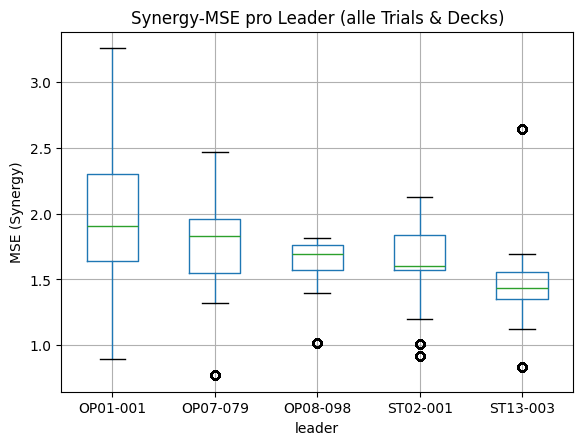

In [ ]:
if not df_final.empty:
    # Boxplot synergy_mse pro Leader
    plt.figure(figsize=(8,5))
    df_final.boxplot(column="synergy_mse", by="leader")
    plt.title("Synergy-MSE pro Leader (alle Trials & Decks)")
    plt.suptitle("")
    plt.ylabel("MSE (Synergy)")
    plt.show()
else:
    print("df_final is empty.")

In [24]:

print(f"Final merged shape: {df_final.shape}")
df_final.head() 

Final merged shape: (25000, 9)


,leader,gnn_trial,deck_trial,score,meta_overlap,avg_synergy,num_singletons,deck_size,synergy_mse
0,OP01-001,1,1,2853.559082,0,2.063501,5,50,1.792633
1,OP01-001,1,2,2815.091309,1,2.047359,5,50,1.792633
2,OP01-001,1,3,2837.621826,1,2.053221,5,50,1.792633
3,OP01-001,1,4,2853.666748,1,2.061460,5,50,1.792633
4,OP01-001,1,5,2840.410645,3,2.057597,5,50,1.792633


In [ ]:
import os
import json
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

target_leader_id = "OP01-001"  # Leader OP01-001
model_file = "models/archive/20250310_094344_gnn_model_OP01-001.pth"

with open("data/labeled_cards.json", "r") as f:
    cards_data = json.load(f)
with open("data/one_piece_deck_lists.json", "r") as f:
    decks_data = json.load(f)
with open("graphs/card_synergies.json", "r") as f:
    known_synergies_data = json.load(f)

leader_card = next((c for c in leaders if c["id"] == target_leader_id), None)
if leader_card is None:
    raise ValueError(f"Leader {target_leader_id} not found!")

leader_color = get_card_colors(leader_card)
leader_arche = leader_card.get("archetype", "").strip()
relevant_decks = gather_decks_for_color_archetype(leader_color, leader_arche, decks_data) or decks_data

known_synergy_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0)
synergy_graph = build_synergy_graph(relevant_decks, leader_arche, leader_color, synergy_weight=2.0, known_synergy_edges=known_synergy_edges)

freq_map = compute_card_frequency(relevant_decks)
usage_map = compute_archetype_usage_ratio(relevant_decks, leader_arche)

data_pyg, node_labels_np = build_pyg_data(cards_data, synergy_graph, freq_map, usage_map)

mean_val = node_labels_np.mean()
std_val = node_labels_np.std() or 1.0

# instantiate model and load
in_dim = data_pyg.x.shape[1]
model = MultiTaskGNN(in_dim=in_dim, hidden_dim=128, emb_dim=64, dropout=0.5, num_layers=4)
model = load_model(model, model_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# reconstruct synergy matrix
synergy_matrix, node_score = build_synergy_matrix(model, data_pyg, freq_map, node_labels_np, mean_val, std_val)

best_deck_data = {
    "OP01-006": 4,
    "OP01-029": 3,
    "OP01-022": 3,
    "OP01-017": 3,
    "OP01-013": 2,
    "OP01-120": 2,
    "OP01-025": 4,
    "ST01-012": 3,
    "ST01-011": 3,
    "ST01-015": 3,
    "OP02-011": 3,
    "OP02-008": 1,
    "OP02-015": 3,
    "P-013": 3,
    "P-019": 1,
    "OP03-018": 3,
    "OP03-020": 3,
    "OP04-016": 3
}


deck_vec = [0] * len(cards_data)
for cid, copies in best_deck_data.items():
    idx = card_id_to_index[cid]
    deck_vec[idx] = copies


Model loaded from: models/archive/20250310_094344_gnn_model_OP01-001.pth


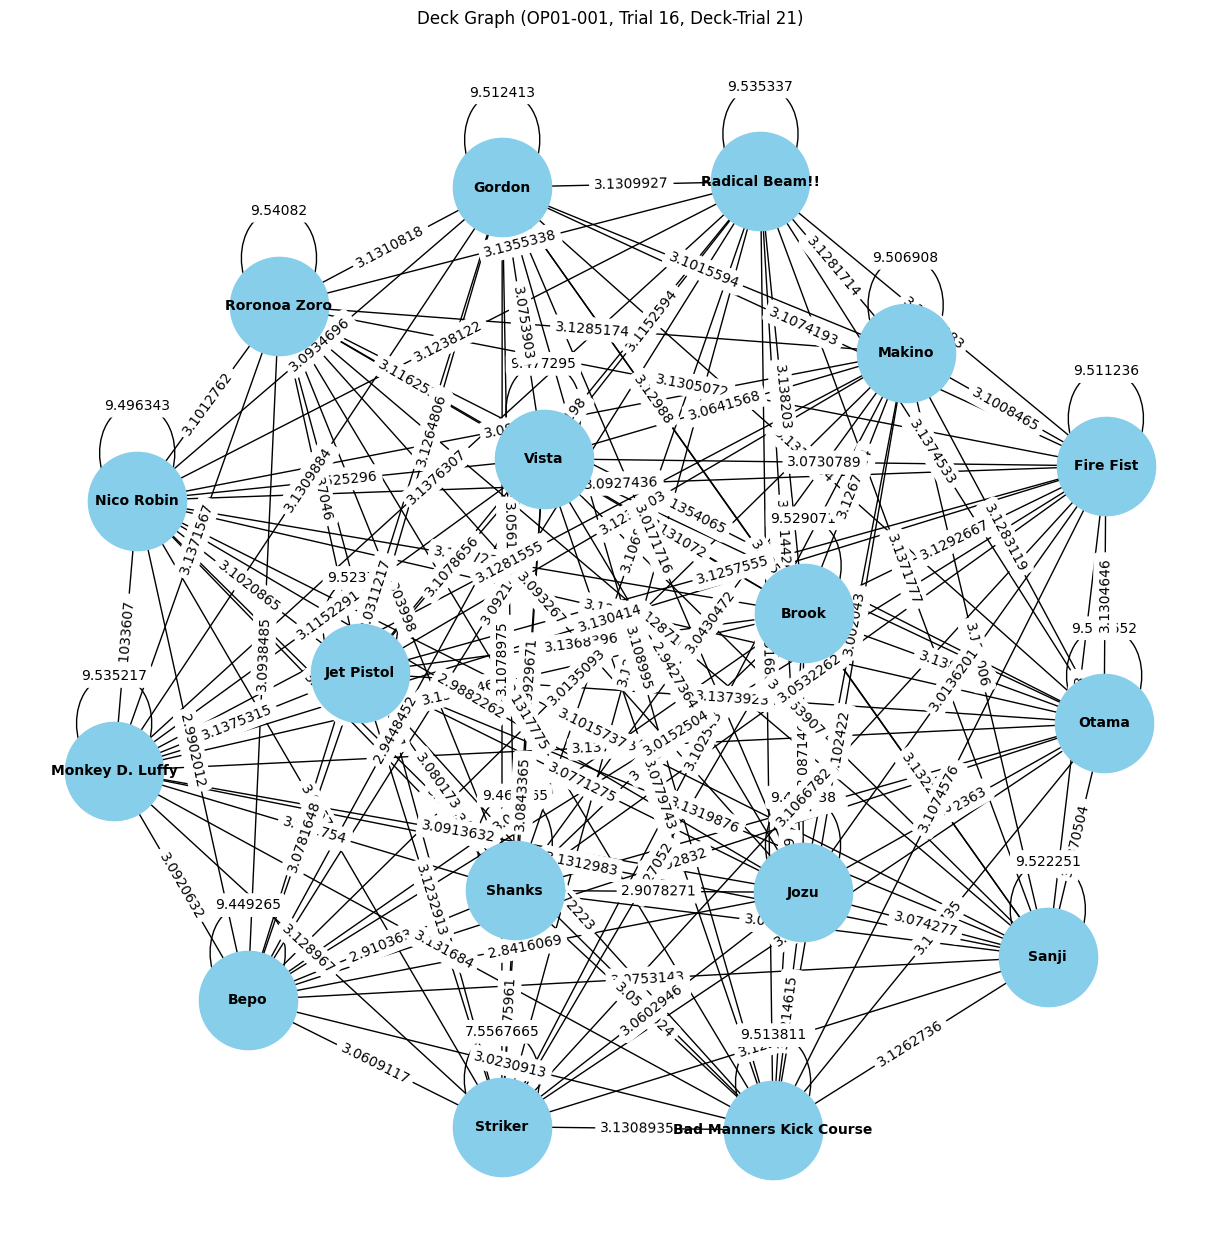

In [45]:
generate_deck_graph(deck_vec, synergy_matrix, title="Deck Graph (OP01-001, Trial 16, Deck-Trial 21)")

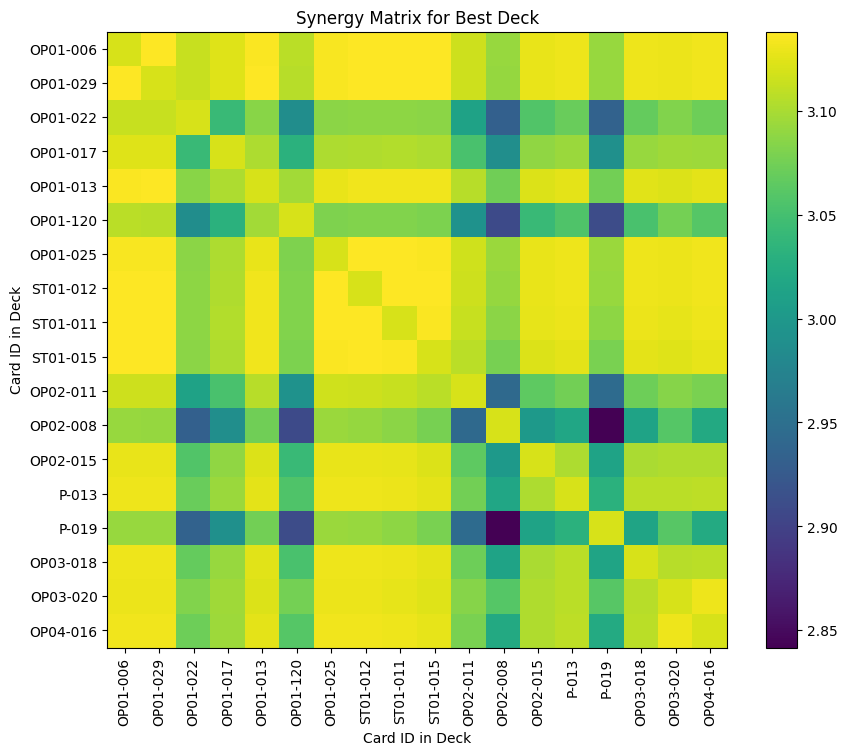

In [ ]:
deck_idxs = np.where(deck_vec)[0]
card_ids = [cards_data[i]["id"] for i in deck_idxs]

best_deck_synergy = synergy_matrix[np.ix_(deck_idxs, deck_idxs)]
np.fill_diagonal(best_deck_synergy, 3.12)

plt.figure(figsize=(10, 8))
plt.imshow(best_deck_synergy, aspect='auto', origin='upper', interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.xticks(ticks=np.arange(len(card_ids)), labels=card_ids, rotation=90)
plt.yticks(ticks=np.arange(len(card_ids)), labels=card_ids)
plt.title("Synergy Matrix for Best Deck")
plt.xlabel("Card ID in Deck")
plt.ylabel("Card ID in Deck")
plt.show()

In [46]:
print("Detailed cards in deck:")
label_counts = {}

for cid, copies in best_deck_data.items():
    cinfo = next((c for c in cards_data if c["id"] == cid), {})
    labels = cinfo.get('labels', [])
    print(f"{copies}x {cid} - {cinfo.get('name', '?')} | Typ: {cinfo.get('type', '?')}, Labels: {labels}")
    for label in labels:
        label_counts[label] = label_counts.get(label, 0) + copies

print("\nLabel frequencies in deck:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Detailed cards in deck:
4x OP01-006 - Otama | Typ: Character, Labels: ['Debuff Power', 'Low Cost']
3x OP01-029 - Radical Beam!! | Typ: Event, Labels: ['Counter', 'Trigger', 'Buff Power', 'Low Cost']
3x OP01-022 - Brook | Typ: Character, Labels: ['Debuff Power', 'Mid Cost']
3x OP01-017 - Nico Robin | Typ: Character, Labels: ['Removal', 'Low Cost']
2x OP01-013 - Sanji | Typ: Character, Labels: ['Low Cost']
2x OP01-120 - Shanks | Typ: Character, Labels: ['Rush', 'Blocker', 'High Cost']
4x OP01-025 - Roronoa Zoro | Typ: Character, Labels: ['Rush', 'Low Cost']
3x ST01-012 - Monkey D. Luffy | Typ: Character, Labels: ['Rush', 'Blocker', 'Mid Cost']
3x ST01-011 - Brook | Typ: Character, Labels: ['Low Cost']
3x ST01-015 - Jet Pistol | Typ: Event, Labels: ['Trigger', 'Removal', 'Mid Cost']
3x OP02-011 - Vista | Typ: Character, Labels: ['Removal', 'Low Cost']
1x OP02-008 - Jozu | Typ: Character, Labels: ['Rush', 'Mid Cost']
3x OP02-015 - Makino | Typ: Character, Labels: ['Buff Power', 'Low Cost']